In [1]:
import tablib
import ujson as json
import pyexcel as pe
import pandas as pd
from time import perf_counter
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import numpy as np
from typing import Generator, Dict, List

In [2]:
filePath = r'C:\OmicData\LiGroupWork\PDBeAPI\0117\4w9p_residue_listing.json'
with open(filePath, 'r') as jsonFile:
    data = json.load(jsonFile)

In [3]:
def performance(record: List, func, *args):
    t0 = perf_counter()
    res = func(*args)
    cost = perf_counter() - t0
    record.append(cost)
    # print(cost)
    return res

In [4]:
 def yieldResidues(data: Dict) -> Generator:
    for pdb in data:
        molecules = data[pdb]['molecules']
        for entity in molecules:
            chains = entity['chains']
            for chain in chains:
                residues = chain['residues']
                yield residues, chain['chain_id'], chain['struct_asym_id'], entity['entity_id'], pdb

In [5]:
def sync_with_pyexcel(residues, chain_id, struct_asym_id, entity_id, pdb_id):
    sheet = pe.get_sheet(records=residues, name_columns_by_row=0)
    append_data = [['chain_id', 'struct_asym_id', 'entity_id', 'pdb_id']] + [[chain_id, struct_asym_id, entity_id, pdb_id]]*len(residues)
    sheet.column += pe.Sheet(append_data)
    return sheet

def sync_with_dataframe(residues, chain_id, struct_asym_id, entity_id, pdb_id):
    dfrm = pd.DataFrame(residues)
    dfrm['pdb_id'] = pdb_id
    dfrm['entity_id'] = entity_id
    dfrm['struct_asym_id'] = struct_asym_id
    dfrm['chain_id'] = chain_id
    return dfrm

In [6]:
 def pyexcel_io(data: Dict, kwargs):
    for res in yieldResidues(data):
        try:
            cur_sheet.row += sync_with_pyexcel(*res)
        except NameError:
            cur_sheet = sync_with_pyexcel(*res)
    cur_sheet.save_as(**kwargs)
    return cur_sheet
    

def pandas_concat_io(data: Dict, kwargs):
    dfrm = pd.concat((sync_with_dataframe(*res) for res in yieldResidues(data)), sort=False)
    dfrm.to_csv(**kwargs)
    return dfrm

def pandas_append_io(data: Dict, kwargs):
    dfrm = None
    for res in yieldResidues(data):
        try:
            dfrm = dfrm.append(sync_with_dataframe(*res) , ignore_index=True, sort=False)
        except AttributeError:
            dfrm = sync_with_dataframe(*res) 
    dfrm.to_csv(**kwargs)
    return dfrm

In [7]:
# sheet.save_as(filename=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\sheet_0214.tsv', delimiter='\t')
# pyexcel_io(data)
# pandas_concat_io(data)
# pandas_append_io(data)
pyexcel_io_perf, pandas_concat_io_perf, pandas_append_io_perf = [], [], []

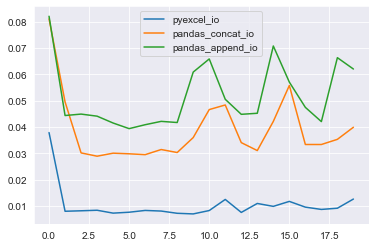

In [8]:
for _ in range(20):
    performance(
        pyexcel_io_perf, 
        pyexcel_io, 
        data, 
        {'filename': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pyexcel_io_0214.tsv', 
        'delimiter': '\t'})
    performance(
        pandas_concat_io_perf, 
        pandas_concat_io, 
        data, 
        {'path_or_buf': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pandas_concat_io_0214.tsv', 
        'sep': '\t', 
        'index': False})
    performance(
        pandas_append_io_perf, 
        pandas_append_io, 
        data,
        {'path_or_buf': r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\pandas_append_io_0214.tsv', 
        'sep': '\t', 
        'index': False})

len_x = len(pyexcel_io_perf)
plt.plot(list(range(len_x)), pyexcel_io_perf, label='pyexcel_io')
plt.plot(list(range(len_x)), pandas_concat_io_perf, label='pandas_concat_io')
plt.plot(list(range(len_x)), pandas_append_io_perf, label='pandas_append_io')
plt.legend()


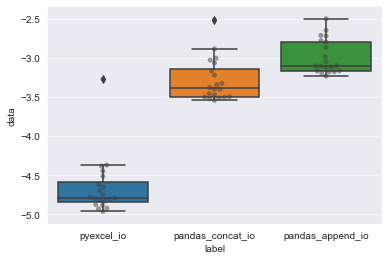

In [9]:
# boxplot
plot_dfrm = pd.DataFrame({'data': pyexcel_io_perf+pandas_concat_io_perf+pandas_append_io_perf, 'label':['pyexcel_io']*len_x + ['pandas_concat_io']*len_x + ['pandas_append_io']*len_x})
plot_dfrm['data'] = plot_dfrm['data'].apply(np.log)
sns.boxplot(x='label', y='data', data=plot_dfrm)
sns.swarmplot(x="label", y="data", data=plot_dfrm, color=".25", alpha=0.5)

In [10]:

ob = tablib.Dataset()

In [11]:
test = data['4w9p']['molecules'][0]['chains'][0]['residues']

In [12]:
# pe.get_sheet(records=test)
# pe.load_from_records(test)
ob.dict = test[50:70]

In [13]:
sheet = pe.get_sheet(records=test, name_columns_by_row=0)
lyst = [['pdb_id', 'chain_id']] + [['test_id', 'test_chain']]*len(test)
sheet.column += pe.Sheet(lyst)
sheet

author_insertion_code,author_residue_number,observed_ratio,residue_name,residue_number,pdb_id,chain_id
,13,0,GLY,1,test_id,test_chain
,14,0,ALA,2,test_id,test_chain
,15,0,PRO,3,test_id,test_chain
,16,0,ALA,4,test_id,test_chain
,17,0,THR,5,test_id,test_chain
,18,0,VAL,6,test_id,test_chain
,19,1,THR,7,test_id,test_chain
,20,1,GLU,8,test_id,test_chain
,21,1,GLN,9,test_id,test_chain
,22,1,GLY,10,test_id,test_chain


In [14]:
test[38:42]

[{'residue_number': 39,
  'author_residue_number': 51,
  'author_insertion_code': '',
  'residue_name': 'ASP',
  'observed_ratio': 1},
 {'residue_number': 40,
  'author_residue_number': 52,
  'author_insertion_code': '',
  'residue_name': 'LYS',
  'observed_ratio': 1},
 {'multiple_conformers': [{'residue_name': 'VAL', 'alternate_conformers': 2}],
  'residue_number': 41,
  'author_residue_number': 53,
  'author_insertion_code': '',
  'residue_name': 'VAL',
  'observed_ratio': 1},
 {'residue_number': 42,
  'author_residue_number': 54,
  'author_insertion_code': '',
  'residue_name': 'TYR',
  'observed_ratio': 1}]

In [18]:

pyexcel_lyst, dataframe_lyst, tablib_lyst = [], [], []

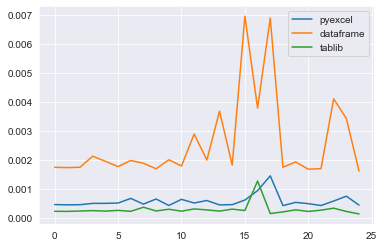

In [19]:
 for _ in range(25):
    t0 = perf_counter()
    pe.load_from_records(test[50:70])
    pyexcel_lyst.append(perf_counter() - t0)
    # 
    t0 = perf_counter()
    pd.DataFrame(test[50:70])
    dataframe_lyst.append(perf_counter() - t0)
    # 
    t0 = perf_counter()
    ob.dict = test[50:70]
    tablib_lyst.append(perf_counter() - t0)


len_x = len(pyexcel_lyst)
plt.plot(list(range(len_x)), pyexcel_lyst, label='pyexcel')
plt.plot(list(range(len_x)), dataframe_lyst, label='dataframe')
plt.plot(list(range(len_x)), tablib_lyst, label='tablib')
plt.legend()

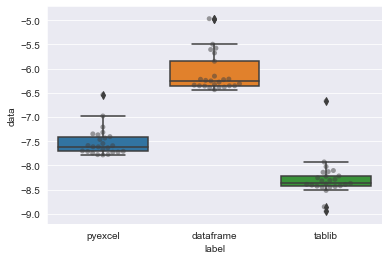

In [20]:

plot_dfrm = pd.DataFrame({'data': pyexcel_lyst+dataframe_lyst+tablib_lyst, 'label':['pyexcel']*len_x + ['dataframe']*len_x + ['tablib']*len_x})
plot_dfrm['data'] = plot_dfrm['data'].apply(np.log)
sns.boxplot(x='label', y='data', data=plot_dfrm)
sns.swarmplot(x="label", y="data", data=plot_dfrm, color=".25", alpha=0.5)
# sns.violinplot(x="label", y="data", data=plot_dfrm, alpha=0.5)